In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

import numpy as np
import pandas as pd 
import json

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import BertTokenizer, get_linear_schedule_with_warmup

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix

import random
import wandb

import sys
sys.path.append('/home/inaki/host_data')
import models
from utils import train_loop, evaluate, evaluate_kfold_ensemble
from CreateDataset import BertDataset

In [2]:
!cat ~/.local/share/jupyter/runtime/jpserver-1.json
# http://g4.etsisi.upm.es:8898/?token=

{
  "base_url": "/",
  "hostname": "0.0.0.0",
  "password": false,
  "pid": 1,
  "port": 8888,
  "root_dir": "/home/inaki",
  "secure": false,
  "sock": "",
  "token": "985c16b5524e38ca6728f8f0fc8f051b7a4868e22457c765",
  "url": "http://ab29586d7002:8888/",
  "version": "2.14.0"
}

In [3]:
########################################
#                Ideas                 #
########################################

# Data Augmentation

    # Otros metodos 
        # Easy methods
        #     Synonym Replacement  |  Random synonym Insertion   |   Random Swap   |    Random Deletion
        # Albumentation (libreria)
        # Libreria para muchos de estos métodos  -  NLPAug 
        

    # Aumentado sobre embedding
        # Añadir ruido gaussiano
        # Ruido adversial
        # MixUp  (mezclar embedding y su label en la proporcion dada por una funcion)
        
    # Consistency regularization ??
    

# TO DO tutorias

    # Remplazo de sinonimos
    # Probar decay de scl
    # Arreglar loss en Evaluate (Esta haciendo solo la cross-entropy)

    # Tecnicas basicas de data aumentacion
        # Round Trip transltion
        # MixUp
        # Ruido gaussiano

    # Volver a probar aumentado de datos con llama3
        
    # Probar CLS en vez de Mean Pooling ?


# Probar otros modelos

# ----------
    # Analizar matriz de confusion sobre baseline
    # Bert ajustado para mensajes de redes sociales (telegram)
    # investigar Equilibrado transformers
    
# Recently DONE
    # Implementar yo el contrastive learning.  Probar con vectores muy sencillos a mano. revisar detach. cambiar a torch.
    # devolver los logits y no la prediccion (y cambiar el BCE por el de logits)
    # Añadir capa densa entre el bert y las neuronas de clasificacion
    
# DONE
    # Investigar *Supervised Contrastive learning 
    # Traduir dataset español y probar
    # Aumentado de datos con llama3 

    # Guardar modelos para probar forma de ensembles
    # Baseline 10 folds sobre test, para tener 10 test como al probar 10 ensembles
    # Plotear distribucion de errores
    # implementar Predicciones 0, 1 o no lo se
    # Matriz de confusion
    # probar los k modelos sobre test
    # Guardar ultimo epoch de validacion, quitar MCC cada epoch, gaurdar media y desviacion del ultimo
    # Mirar si tiene emojis y traducirlos a texto (emojify)

    #  ¿¿¿ #os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8" ???
       # ERROR  # torch.use_deterministic_algorithms(True)  
    # guardar los resultados weight and bias o ML flow
    # Intentar guardar el MCC de cada fold para poder sacar desviaciones
    # Guardar semilas.  La semilla es para que los datos sean los mismos.
    # MCC  poner etiquetas a 1 y 2  ¿¿¿ seguro ???
    # Arreglar docker
    # sacar 10% de datos del dataset como sanity-check 
    # split stratify   (sklearn viene)
    # cross validation (sklearn)

In [4]:
###############################
#       configuración         #
###############################
MODEL_NAME = "BertBaseDenseLogits"

MAX_LENGTH = 512
HEAD_DROPOUT = 0.0
DATA_AUGMENTATION = [] #["Oversampling"] # '_es_into_en' # 'llama_aug'
FOLDS_NUM = 10

NUM_EPOCHS = 5
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
DECAY = None

LOSS_FN =  'supervised_contrastive' # 'cross_entropy' # 'supervised_contrastive'

temperature = 0.3  # temprature for contrastive loss
lam = 0.9  # lambda for loss

checkoint_folder = 'Baseline'

datadir = "/home/inaki/host_data/dataset_oppositional/"
cuda_device = 1
wandb_project = 'BASELINE'    # 'BASELINE'  'Ensemble_baseline' 'trash'

In [5]:
# Cargamos los datasets de entrenamiento y test
train_en_dataset_path = datadir + "train_en_data.pth"
test_en_dataset_path = datadir + "test_en_data.pth"
train_es_dataset_path = datadir + "train_es_data.pth"
test_es_dataset_path = datadir + "test_es_data.pth"

# Dataset traducido por llama3 8B
train_es_translated_path = datadir + "train_es_translated_data.pth"

# creamos los datasets de test
X, y = torch.load(test_es_dataset_path)
test_es_dataset = BertDataset(X, y)
X, y = torch.load(test_en_dataset_path)
test_en_dataset = BertDataset(X, y)

#Creamos dataloader de test
test_en_dataloader = DataLoader(test_en_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
##################################
#     Weigths and bias Login    #
##################################
# MY API KEY
#    240062b42b3367d962eecb38802f856b41245735
wandb.login(key="240062b42b3367d962eecb38802f856b41245735")

for i in range(1):
    print(f"experimento {i}:")
    #####################
    #  Reproducibilidad #
    #####################
    SEED = random.randint(0,10000)
    print(f"seed: {SEED}")
    # fuente  -  https://pytorch.org/docs/stable/notes/randomness.html
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True


    ######################################
    #          K-FOLD TRAIN LOOP         #
    ######################################

    # CROSS VALIDATION LOOP
    X, y = torch.load(train_en_dataset_path)
    X = np.array(X)
    y = np.array(y)

    if "_es_into_en" in DATA_AUGMENTATION:
        X_tr, y_tr = torch.load(train_es_translated_path)
        X_tr, y_tr = np.array(X_tr), np.array(y_tr)

    if "llama_aug" in DATA_AUGMENTATION:
        X_aug, y_aug = torch.load(datadir + "train_en_data_AUG_1-2.pth")
        X_aug, y_aug = np.array(X_aug), np.array(y_aug)


    skf = StratifiedKFold(n_splits=FOLDS_NUM, shuffle=True, random_state=42)

    k_test_outputs = []
    # Loop over the folds
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"fold {fold_idx + 1}")
        
        # Weigths and bias init
        config = {
        "MAX_LENGTH": MAX_LENGTH,
        "HEAD_DROPOUT": HEAD_DROPOUT,
        "DATA_AUGMENTATION": DATA_AUGMENTATION,
        "FOLDS_NUM": FOLDS_NUM,
        "NUM_EPOCHS": NUM_EPOCHS,
        "LEARNING_RATE": LEARNING_RATE,
        "BATCH_SIZE": BATCH_SIZE,
        "FOLD_IDX": fold_idx,
        "DATA_AUGMENTATION": DATA_AUGMENTATION,
        "LOSS_FN": LOSS_FN,
        "SEED": SEED
        }
        GROUP = f"{MODEL_NAME}_{HEAD_DROPOUT}_{BATCH_SIZE}_{LEARNING_RATE}_{DATA_AUGMENTATION}_{LOSS_FN}"
        if LOSS_FN == 'supervised_contrastive':
            GROUP += f"_{temperature}_{lam}"
            # GROUP += f"_{temperature}_{lam}_{DECAY}"
        wandb.init(project=wandb_project, group=GROUP, config=config)
        
        # Create the fold-specific train and validation sets
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # mapeo indices de los originales a sus aumentaciones 1 a 2
        if "llama_aug" in DATA_AUGMENTATION:
            train_aug_idx = []
            for idx in train_index:
                train_aug_idx += [idx*2, idx*2 +1]  # Esto esta hardcodeado a que sea 1 a 2
            X_aug_train, y_aug_train = X_aug[train_aug_idx], y_aug[train_aug_idx]
            # Concateno los datos aumentados
            X_train_fold = np.concatenate((X_train_fold, X_aug_train))
            y_train_fold = np.concatenate((y_train_fold, y_aug_train))

        #El de entrenamiento le añado el dataset traducido
        if "_es_into_en" in DATA_AUGMENTATION:
            X_train_fold = np.concatenate((X_train_fold, X_tr))
            y_train_fold = np.concatenate((y_train_fold, y_tr))

        # MixUP
        if LOSS_FN == 'MixUp':
            # separamos el dataset entre positivos y negativos.  
            ###  ¡¡  OJO estamos usando tambien el aumentado de llama y el traducido  !!
            positive = BertDataset(X_train_fold[y_train_fold == 1], y_train_fold[y_train_fold == 1])
            negative = BertDataset(X_train_fold[y_train_fold == 0], y_train_fold[y_train_fold == 0])
            # sacamos un ejemplo de cada uno
            positive_example = positive[np.random.randint(0, len(positive))]
            negative_example = negative[np.random.randint(0, len(negative))]
            print(f"Positive example {positive_example}")
            print(f"Negative example {negative_example}")
        else:
            positive = None
            negative = None

        # Creo los datasets de entrenamiento y validación.
        train_en_dataset = BertDataset(X_train_fold, y_train_fold)
        val_en_dataset = BertDataset(X_val_fold, y_val_fold)
        
        # Create the train dataloader with a random oversampling of the minority class
        if "Oversampling" in DATA_AUGMENTATION:
            # Oversampling Train Dataloader
            labels = [sample[2] for sample in train_en_dataset]
            class_counts = torch.bincount(torch.tensor(labels))
            class_weights = 1.0 / class_counts.float()

            weights = [class_weights[label] for label in labels]
            sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_en_dataset), replacement=True)
            train_en_dataloader = DataLoader(train_en_dataset, sampler=sampler, batch_size=BATCH_SIZE)
            print(f"Oversampling")
        else:
            print(f"No Oversampling")
            train_en_dataloader = DataLoader(train_en_dataset, batch_size=BATCH_SIZE, shuffle=True)
            
        val_en_dataloader = DataLoader(val_en_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        # Instanciamos el modelo cuya clase viene dada por la variable MODEL_NAME
        # Obtén la referencia a la clase del módulo models
        ModelClass = getattr(models, MODEL_NAME)
        model = ModelClass(dropout_prob=HEAD_DROPOUT, dense_dim=32)
        
        device = torch.device(f"cuda:{cuda_device}" if torch.cuda.is_available() else "cpu")
        print(device)
        model.to(device)
        
        # Paralelizamos el modelo si hay mas de una GPU
        if torch.cuda.device_count() > 5:
            model = nn.DataParallel(model, device_ids=[0, 1])
            
        # Define your loss function (binary cross-entropy in this case)
        criterion = nn.BCELoss()
          
        # Activamos todas las capas
        for param in model.parameters():
            param.requires_grad = True
        
        # Contmaos los parametros entrenables
        print(f"total params: {sum(p.numel() for p in model.parameters())} trainble params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
        

        # Define your optimizer
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
        
        # Define your learning rate scheduler
        total_steps = len(train_en_dataloader) * NUM_EPOCHS
        warmup_steps = int(total_steps * 0.1)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
        
        # debug pytorch version of contrastive loss
        # from utils import test_contrastive_loss
        #test_contrastive_loss(model, train_en_dataloader, temperature, lam, device)

        # Train the model
        train_loop(model, train_en_dataloader, positive, negative, optimizer, scheduler, NUM_EPOCHS, temperature, lam, DECAY, LOSS_FN, device)
        
        # Evaluate the model
        _ = evaluate(model, val_en_dataloader, 0.5, device, val_or_test="Val")
        k_test_outputs += [evaluate(model, test_en_dataloader, 0.5, device, val_or_test="Test")]
        
        # Save the model
        torch.save(model.state_dict(), f"/home/inaki/host_data/checkpoints/{checkoint_folder}/{GROUP}_exp-{i}_fold_{fold_idx}.pth")
    evaluate_kfold_ensemble(k_test_outputs, test_en_dataloader)
        
    # bB - Finalizamos el experimento
    wandb.finish()

wandb: Currently logged in as: inakitodc (inaki). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/inaki/.netrc


experimento 0:
seed: 2320
fold 1


No Oversampling
cuda:1
total params: 109506881 trainble params: 109506881


Epoch 1/5: 100%|██████████| 203/203 [01:36<00:00,  2.11batch/s, loss=12.7]


Epoch 1, Average Train Loss: 38.157678599428074


Epoch 2/5: 100%|██████████| 203/203 [01:35<00:00,  2.12batch/s, loss=12.5]


Epoch 2, Average Train Loss: 35.36915361000399


Epoch 3/5: 100%|██████████| 203/203 [01:34<00:00,  2.14batch/s, loss=9.2] 


Epoch 3, Average Train Loss: 32.38704247310244


Epoch 4/5: 100%|██████████| 203/203 [01:34<00:00,  2.15batch/s, loss=8.96]


Epoch 4, Average Train Loss: 30.590273335649464


Epoch 5/5: 100%|██████████| 203/203 [01:35<00:00,  2.13batch/s, loss=8.91]


Epoch 5, Average Train Loss: 29.951683368588903
Val MCC 0.5 threshold:  0.8148
[[222  14]
 [ 16 108]]
Average Val Loss: 0.2585
Test MCC 0.5 threshold:  0.7736
[[241  21]
 [ 20 118]]
Average Test Loss: 0.2713
fold 2


Test_0.5_threshold_MCC,▁
Val_0.5_threshold_MCC,▁
Test_0.5_threshold_MCC,0.77361
Val_0.5_threshold_MCC,0.81483


No Oversampling
cuda:1
total params: 109506881 trainble params: 109506881


Epoch 1/5: 100%|██████████| 203/203 [01:36<00:00,  2.11batch/s, loss=12.2]


Epoch 1, Average Train Loss: 38.27199532833006


Epoch 2/5: 100%|██████████| 203/203 [01:35<00:00,  2.12batch/s, loss=12.4]


Epoch 2, Average Train Loss: 35.326858121186056


Epoch 3/5: 100%|██████████| 203/203 [01:36<00:00,  2.11batch/s, loss=8.29]


Epoch 3, Average Train Loss: 32.54103114217373


Epoch 4/5: 100%|██████████| 203/203 [01:35<00:00,  2.13batch/s, loss=9.1] 


Epoch 4, Average Train Loss: 30.87740306666332


Epoch 5/5: 100%|██████████| 203/203 [01:35<00:00,  2.14batch/s, loss=14.1]


Epoch 5, Average Train Loss: 30.209534753132335
Val MCC 0.5 threshold:  0.7494
[[214  22]
 [ 19 105]]
Average Val Loss: 0.2934
Test MCC 0.5 threshold:  0.7855
[[241  21]
 [ 18 120]]
Average Test Loss: 0.2804
fold 3


Test_0.5_threshold_MCC,▁
Val_0.5_threshold_MCC,▁
Test_0.5_threshold_MCC,0.78548
Val_0.5_threshold_MCC,0.74938


No Oversampling
cuda:1
total params: 109506881 trainble params: 109506881


Epoch 1/5: 100%|██████████| 203/203 [01:35<00:00,  2.13batch/s, loss=14.5]


Epoch 1, Average Train Loss: 38.16984464147408


Epoch 2/5: 100%|██████████| 203/203 [01:35<00:00,  2.12batch/s, loss=12.9]


Epoch 2, Average Train Loss: 35.404292919365645


Epoch 3/5: 100%|██████████| 203/203 [01:36<00:00,  2.11batch/s, loss=13.2]


Epoch 3, Average Train Loss: 32.30804158666451


Epoch 4/5:  64%|██████▎   | 129/203 [01:00<00:35,  2.10batch/s, loss=31]  

In [ ]:
#### Bucle cargando todos los modelos BASELINE
baseline_test_outputs = []

# Filtramos los modelos que queremos evaluar
modelos = os.listdir("/home/inaki/host_data/checkpoints/Baseline/")
modelos = [m for m in modelos if m.startswith('BertBasePooledOutput_exp-0_0.0_[]')]
# modelos = [m for m in modelos if m.startswith(GROUP)]

for model_path in modelos:
    model = ModelClass(dropout_prob=HEAD_DROPOUT)
    # Load the saved state dictionary into the initialized model
    state_dict = torch.load('/home/inaki/host_data/checkpoints/Baseline/' + model_path)
    # Remove the 'module.' prefix from keys if present (esto es por ser un modelo paralelizado)
    if 'module.' in list(state_dict.keys())[0]:
        state_dict = {key[7:]: value for key, value in state_dict.items()}
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()
    baseline_test_outputs += [evaluate(model, test_en_dataloader, THRESHOLD=0.5, val_or_test="Test")]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.7992
[[247  15]
 [ 21 117]]
Average Test Loss: 0.3263


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.8155
[[251  11]
 [ 22 116]]
Average Test Loss: 0.2987


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.8155
[[251  11]
 [ 22 116]]
Average Test Loss: 0.3015


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.7874
[[248  14]
 [ 24 114]]
Average Test Loss: 0.3245


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.7877
[[247  15]
 [ 23 115]]
Average Test Loss: 0.3099


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.7891
[[244  18]
 [ 20 118]]
Average Test Loss: 0.3227


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.8156
[[250  12]
 [ 21 117]]
Average Test Loss: 0.2920


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.8108
[[247  15]
 [ 19 119]]
Average Test Loss: 0.2987


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.7604
[[243  19]
 [ 24 114]]
Average Test Loss: 0.3380


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.7992
[[247  15]
 [ 21 117]]
Average Test Loss: 0.3110


,mcc,low,up
600,0.810427,0.49,0.50
450,0.810427,0.43,0.50
475,0.810427,0.44,0.50
525,0.810427,0.46,0.50
575,0.810427,0.48,0.50
...,...,...,...
47,0.763822,0.26,0.72
48,0.763822,0.26,0.73
24,0.759629,0.25,0.74
22,0.759629,0.25,0.72


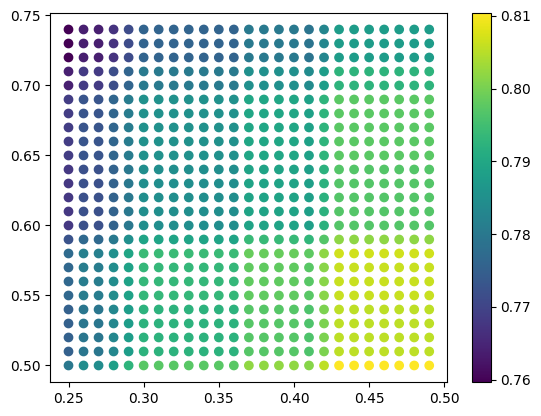

In [ ]:
# Evaluamos el valor optimo para el threshold
test_true_labels = []
for data in test_en_dataloader:
    input_ids, attention_mask, labels, _ = data
    test_true_labels += labels.tolist()

all_mcc = []
threshold = []
low, up = [], []
test_outputs = np.array(baseline_test_outputs)
test_outputs = test_outputs.mean(axis=0)
for i in range(25, 50):
    for j in range(50, 75):
        test_mean_predictions = [0 if x < i/100 else (1 if x > j/100 else -1) for x in test_outputs]
        mcc = matthews_corrcoef(test_true_labels, test_mean_predictions)
        all_mcc += [mcc]
        low += [i/100]
        up += [j/100]
        # create a df with the results and sort by mcc

df = pd.DataFrame({'mcc':all_mcc, 'low':low, 'up':up})
df = df.sort_values('mcc', ascending=False)
display(df)

# plot que representa en los ejes x e y los valores de low y up y en el eje z el mcc
plt.scatter(df['low'], df['up'], c=df['mcc'], cmap='viridis')
plt.colorbar()
plt.show()


In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>", raw=True)